### Null test

In this notebook, I am going to try the presented approach on a model which does not have any meaningful structure and see how the classifier can split the points into two classes.

In [1]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute
import qiskit.extensions.quantum_initializer as qeqi
import time
from scipy.optimize import minimize, approx_fprime
import matplotlib.pyplot as plt
import scipy.sparse.linalg as SPLA
import csv
import pandas as pd
from functools import reduce
from skopt import gp_minimize
from numba import jit, njit
from copy import copy, deepcopy


import Entangler
import TensorNetwork
import hamiltonians
import TNOptimize
import uuid
import json
import utils

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.figsize': [9, 6]})

/home/alexey/quantumenv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


In [13]:
n_qubits = 4

n_points_total = 10

depth = 3
classifier_depth = 3
ent = Entangler.IsingEntangler()
tol = 1e-6

In [14]:
q = QuantumRegister(n_qubits)
c = ClassicalRegister(n_qubits)
TN = TensorNetwork.Checkerboard(q, c, ent, depth=depth)


H_1 = np.random.randn(2**n_qubits, 2**n_qubits) + 1j * np.random.randn(2**n_qubits, 2**n_qubits)
H_1 = 0.5 * (H_1 + H_1.T.conj())
print(np.linalg.norm(H_1 - H_1.T.conj()))

0.0


In [15]:
H_2 = np.random.randn(2**n_qubits, 2**n_qubits) + 1j * np.random.randn(2**n_qubits, 2**n_qubits)
H_2 = 0.5 * (H_2 + H_2.T.conj())

In [16]:
def H(alpha):
    return (1 - alpha) * H_1 + alpha * (H_2)

In [17]:
labels = np.ones(n_points_total)
vectors = np.zeros((2**n_qubits, n_points_total), dtype=np.complex64)
parameters = np.zeros((TN.n_params, n_points_total))
vqe_energies = np.zeros(n_points_total)
exact_energies = np.zeros(n_points_total)

In [18]:
alphas = np.linspace(0, 1, n_points_total)

start_vals = np.random.rand(TN.n_params) * 0.2


for i, alpha in enumerate(alphas):
    H_current = H(alpha)
    if alpha>0.5:
        labels[i] = 1
    else:
        labels[i] = -1
    f = TNOptimize.build_objective_function(TN, explicit_H=H_current)

    n_iters = 0
    start_time = time.time()
    res = minimize(f, start_vals, options={'maxiter': 300}, callback=None, 
                   tol=tol, method="L-BFGS-B")
    time_spent = time.time() - start_time
    print('Elapsed time: {0:5.2f}'.format(time_spent))
    
    circ = TN.construct_circuit(res.x)
    state = utils.get_state(circ)
    print(res.fun)
    print(res.nit)
    print(res.message)
    
    parameters[:, i] = res.x
    vectors[:, i] = state
    vqe_energies[i] = res.fun
    
    s, v = np.linalg.eigh(H_current)
    
    exact_energies[i] = s[0]
    
    # Warm start
    start_vals = res.x

Elapsed time: 132.47
-6.646990138670466
101
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Elapsed time: 22.92
-5.8666397587474375
19
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Elapsed time: 24.89
-5.157484167767345
20
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Elapsed time: 47.57
-4.711503316329179
37
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Elapsed time: 30.04
-4.398959681268094
25
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Elapsed time: 68.15
-4.416400547568065
57
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Elapsed time: 81.09
-4.989900632712342
67
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Elapsed time: 35.94
-5.668957842686115
31
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Elapsed time: 17.56
-6.396070971897297
14
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Elapsed time: 19.26
-7.15680443110973
15
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [60]:
labels = (labels + 1)/2
print(labels)

[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]


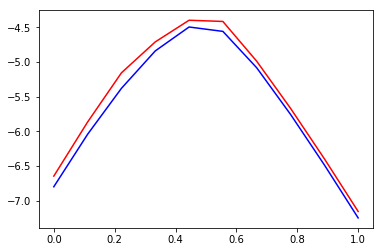

In [61]:
plt.plot(alphas, vqe_energies, 'r')
plt.plot(alphas, exact_energies, 'b')

In [62]:
def count_ones(x):
    count = 0
    x_c = copy(x)
    while x_c != 0:
        x_c = x_c & (x_c-1)
        count += 1
    return count


unitary_backend = Aer.get_backend('unitary_simulator')

def unitary_prediction(state, U):
    """Returns the probability that the state is in class II by
    transforming the circuit into a unitary map"""
#     if U_supply is None:
#         result = execute(NN_circ, unitary_b).result()
#         U = result.get_unitary(NN_circ)
#     else:
#         U = U_supply
    res_state = U @ state
    
    label = [0, 0]
    
    for i in range(len(res_state)):
        qty_ones = count_ones(i)
        if qty_ones > n_qubits // 2:
            label[1] += abs(res_state[i])**2
        elif qty_ones < n_qubits // 2:
            label[0] += abs(res_state[i])**2 / 2 

    return label[1] / (label[0] + label[1])


def build_loss_fun(df, indices, TN_classifier):
    """construct the loss function for a batch
    Works somewhat differently from that in XXZ_model.ipynb
    Here colums are data points np.vstack((vectors, labels))
    df: DataFrame
    indices: column numbers of the points in current batch
    TN_classifier: quantum classifier"""
    

    def f(x):
        circ = TN_classifier.construct_circuit(x)
        result = execute(circ, unitary_backend).result()
        U = result.get_unitary(circ)
        logloss = 0
        for i in indices:
            state = np.array(df.iloc[:-1,i])
            y = df.iloc[-1, i].real
            p = unitary_prediction(state, U)
            logloss += -(y * np.log(p) + (1 - y) * np.log(1 - p))
            
        return logloss / batch_size
    return f

In [63]:
df = pd.DataFrame(data=np.vstack((vectors, labels)))

In [64]:
np.array(df.iloc[-1,5])

array(1.+0.j)

In [65]:
permutation = np.random.permutation(n_points_total)
train_size = int(0.8*n_points_total)
train_indices = permutation[:train_size]
test_indices = permutation[train_size:]
print(train_indices)
print(test_indices)

[3 8 4 9 1 6 0 2]
[7 5]


In [66]:
n_epochs = 100
batch_size = 8

TN_classifier = TensorNetwork.Checkerboard(q, c, ent, depth=classifier_depth)
classifier_vals = np.random.randn(TN_classifier.n_params) * 0.1
x = classifier_vals

lr_base = 5

decay = 1e-3
factor = 1 - decay

eps_base = 5e-2

v = np.zeros(TN_classifier.n_params) #momentum

for epoch in range(n_epochs):
    perm_train = np.random.permutation(train_size)
    current_train_indices = train_indices[perm_train]
#     print(current_train_indices)
    for batch_num in range(train_size // batch_size):
        indices = current_train_indices[batch_num * batch_size: (batch_num + 1) * batch_size]
#         print(indices)
        f = build_loss_fun(df, indices, TN_classifier)
        
        eps = eps_base / (1 + batch_num * (epoch + 1))**0.5
        lr = lr_base / (1 + batch_num * (epoch + 1))**0.5
        
        #grad = approx_fprime(x, f, eps)
        dx = np.random.randn(np.shape(x)[0]) * eps
        f_plus = f(x + dx)
        f_minus = f(x - dx)
        
        grad = (f_plus - f_minus) / 2 / np.linalg.norm(dx)
                                
        v = 0.9 * v - grad * lr * dx
        x = x + v        
        
        loss = (f_plus + f_minus) / 2
        if (epoch % 20 == 0 or epoch < 15):
            print('Epoch {0:d} batch {1:d}'.format(epoch, batch_num))
            print('loss:', loss)                

Epoch 0 batch 0
loss: 1.0502197334666632
Epoch 1 batch 0
loss: 1.0342921992885383
Epoch 2 batch 0
loss: 0.9485049577507972
Epoch 3 batch 0
loss: 0.8721872835064286
Epoch 4 batch 0
loss: 0.8049398849245636
Epoch 5 batch 0
loss: 0.7484950179222654
Epoch 6 batch 0
loss: 0.6915316244514084
Epoch 7 batch 0
loss: 0.6389004764449863
Epoch 8 batch 0
loss: 0.5932078055557911
Epoch 9 batch 0
loss: 0.5495644165108047
Epoch 10 batch 0
loss: 0.5154195400057042
Epoch 11 batch 0
loss: 0.48277870496147685
Epoch 12 batch 0
loss: 0.4638647468201695
Epoch 13 batch 0
loss: 0.4452318168304705
Epoch 14 batch 0
loss: 0.4297642932768995
Epoch 20 batch 0
loss: 0.3806893126580607
Epoch 40 batch 0
loss: 0.27060367569426946
Epoch 60 batch 0
loss: 0.20416275752567806
Epoch 80 batch 0
loss: 0.16435590131551941


In [68]:
NN_circ = TN_classifier.construct_circuit(x)
result = execute(NN_circ, unitary_backend).result()
U = result.get_unitary(NN_circ)

predicted_labels = np.zeros(n_points_total)

for i in range(n_points_total):
    state = np.array(df.iloc[:-1,i])
    p = unitary_prediction(state, U)
    predicted_labels[i] = p  


In [69]:
print(predicted_labels)

[0.13046568 0.09909414 0.07987955 0.20507543 0.31584031 0.78521716
 0.88519622 0.89931505 0.90381511 0.90504671]


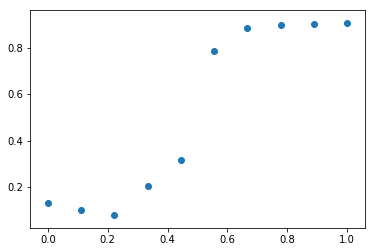

In [70]:
plt.scatter(alphas, predicted_labels)

In [72]:
test_indices

array([7, 5])